In [2]:
import netCDF4
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gsw


In [3]:
path_d = '../../pmelData/6s10w/d6s10w_dy.cdf'
path_s = '../../pmelData/6s10w/s6s10w_dy.cdf'
path_t = '../../pmelData/6s10w/t6s10w_dy.cdf'

In [4]:
ds_d = xr.open_dataset(path_d)
ds_s = xr.open_dataset(path_s)
ds_t = xr.open_dataset(path_t)
print(ds_d)
print(ds_s)
print(ds_t)

<xarray.Dataset> Size: 1MB
Dimensions:   (time: 7597, depth: 9, lat: 1, lon: 1)
Coordinates:
  * time      (time) datetime64[ns] 61kB 2000-03-15T12:00:00 ... 2020-12-31T1...
  * depth     (depth) float32 36B 1.0 5.0 10.0 20.0 40.0 60.0 80.0 100.0 120.0
  * lat       (lat) float32 4B -6.0
  * lon       (lon) float32 4B 350.0
Data variables:
    STH_71    (time, depth, lat, lon) float32 273kB ...
    QST_5071  (time, depth, lat, lon) float32 273kB ...
    SST_6071  (time, depth, lat, lon) float32 273kB ...
    DIC_7071  (time, depth, lat, lon) float32 273kB ...
Attributes:
    platform_code:                6s10w
    site_code:                    6s10w
    wmo_platform_code:            15006
    array:                        PIRATA
    Request_for_acknowledgement:  If you use these data in publications or pr...
    Data_Source:                  Global Tropical Moored Buoy Array Project O...
    File_info:                    Contact: Dai.C.McClurg@noaa.gov
    missing_value:               

In [5]:
ds_d_squeezed = ds_d.squeeze()
ds_s_squeezed = ds_s.squeeze()
ds_t_squeezed = ds_t.squeeze()

# Convert to DataFrame
df_d = ds_d_squeezed.to_dataframe().reset_index()
df_s = ds_s_squeezed.to_dataframe().reset_index()
df_t = ds_t_squeezed.to_dataframe().reset_index()
# df_d.head()
# df_s.head()
df_t.head()

,time,depth,lat,lon,T_20,QT_5020,ST_6020,depzsst,ZSST_2003
0,2000-03-15 12:00:00,1.0,-6.0,350.0,27.959999,1.0,5.0,1.0,1.0
1,2000-03-15 12:00:00,5.0,-6.0,350.0,NaN,0.0,0.0,1.0,1.0
2,2000-03-15 12:00:00,10.0,-6.0,350.0,NaN,0.0,0.0,1.0,1.0
3,2000-03-15 12:00:00,20.0,-6.0,350.0,27.920000,1.0,5.0,1.0,1.0
4,2000-03-15 12:00:00,40.0,-6.0,350.0,27.709999,1.0,5.0,1.0,1.0


In [6]:
# drop lat and lon columns

# for salinity file
df_s = df_s.drop(columns=['lat', 'lon', 'SS_6041', 'QS_5041', 'SIC_8041'])
col_name_s = 'S_41'

# for density file
df_d = df_d.drop(columns=['lat', 'lon', 'QST_5071',	'SST_6071','DIC_7071']) 
col_name_d = 'STH_71'

# for temperature file
df_t = df_t.drop(columns=['lat', 'lon', 'QT_5020','ST_6020','depzsst','ZSST_2003'])
col_name_t = 'T_20'

# in time column, keep the date only # all times are 12:00:00
df_d['time'] = df_d['time'].dt.date
df_s['time'] = df_s['time'].dt.date
df_t['time'] = df_t['time'].dt.date

df_d.head()

,time,depth,STH_71
0,2000-03-15,1.0,23.207001
1,2000-03-15,5.0,NaN
2,2000-03-15,10.0,NaN
3,2000-03-15,20.0,23.212000
4,2000-03-15,40.0,23.280001


In [7]:
# we see unique values in the 'depth' column of df_d, we use this to filter depths in df_s and df_t
unique_depths = df_d['depth'].unique()
print("Unique depths:", unique_depths)

Unique depths: [  1.   5.  10.  20.  40.  60.  80. 100. 120.]


In [8]:
# see which depth has least NaN val in col_name column # 'S_41' (SALINITY) or 'STH_71' (DENSITY)
nans_depths = df_d.groupby('depth')[col_name_d].apply(lambda x: x.isna().sum())
tot_rows = df_d.groupby('depth').size()
# merge the two series into a dataframe
nans_depths_df = pd.DataFrame({'nans': nans_depths, 'tot_rows': tot_rows})
print("Total NaN's by depths:\n ",nans_depths_df)
selected_depth = nans_depths_df['nans'].idxmin()
print("\nMin NaN's at depth: ",selected_depth)

Total NaN's by depths:
         nans  tot_rows
depth                
1.0    1707      7597
5.0    7260      7597
10.0   6933      7597
20.0    770      7597
40.0    826      7597
60.0   6948      7597
80.0   7260      7597
100.0  7260      7597
120.0   515      7597

Min NaN's at depth:  120.0


**looking at the above table, we can choose depths 20,40,120 and possibly 1 also.**
<br>
Rest of the depths have large number of NaN values.

In [9]:
#OVERRIDE THE SELECTED DEPTH
selected_depth  = 120.0

In [10]:
# now take unique depths and keep only those depth rows in df_s and df_t
# df_d = df_d[df_d['depth'] == 0]
df_s = df_s[df_s['depth'].isin(unique_depths)]
df_t = df_t[df_t['depth'].isin(unique_depths)]

In [11]:
#check if the depths are same in all three dataframes
depths_d = df_d['depth'].unique()
depths_s = df_s['depth'].unique()
depths_t = df_t['depth'].unique()

print("Depths in df_d:", depths_d)
print("Depths in df_s:", depths_s)
print("Depths in df_t:", depths_t)

df_d.head()

Depths in df_d: [  1.   5.  10.  20.  40.  60.  80. 100. 120.]
Depths in df_s: [  1.   5.  10.  20.  40.  60.  80. 100. 120.]
Depths in df_t: [  1.   5.  10.  20.  40.  60.  80. 100. 120.]


,time,depth,STH_71
0,2000-03-15,1.0,23.207001
1,2000-03-15,5.0,NaN
2,2000-03-15,10.0,NaN
3,2000-03-15,20.0,23.212000
4,2000-03-15,40.0,23.280001


In [12]:
# merge df_d, df_s and df_t to single dataframe, merge values based on same time and depth
df_merged = pd.merge(df_d, df_s, on=['time', 'depth'], how='outer')
df_merged = pd.merge(df_merged, df_t, on=['time', 'depth'], how='outer')
df_merged.head()

,time,depth,STH_71,S_41,T_20
0,2000-03-15,1.0,23.207001,36.062000,27.959999
1,2000-03-15,5.0,NaN,NaN,NaN
2,2000-03-15,10.0,NaN,NaN,NaN
3,2000-03-15,20.0,23.212000,36.044998,27.920000
4,2000-03-15,40.0,23.280001,36.043999,27.709999


Now we have same depths for all df's and thus merged all into one df.
- for now we will be calculating d(z) from df_t and df_s, and match them to df_d values. 

In [13]:
df = df_merged
# take only rows with depth = 120.0
depth = selected_depth
df = df[df['depth'] == depth]
# drop depth column
df = df.drop(columns=['depth'])
# reindex the dataframe
df = df.reset_index(drop=True)
# till now we haven't dropped any NaN values. We will drop them now.
df = df.dropna()

Now we have our processed df, which we can use to calculate d(z) values.


In [14]:
# already imported gsw library

# following ans from ChatGPT
# p = gsw.p_from_z(-df['depth'].values, lat=0)
# SA = gsw.SA_from_SP(df['S_41'].values, p, lon=0, lat=0)
# CT = gsw.CT_from_t(SA, df['T_21'].values, p)
# sigma_theta = gsw.sigma0(SA, CT)  # <- directly comparable to df['STH_71']


# do for all rows in the dataframe, create new columns for SA, CT and rho
# lat = -6.0 , lon = 350.0
lat = -6.0
lon = 350.0
p = gsw.p_from_z(-depth, lat=lat)
df['SA'] = gsw.SA_from_SP(df[col_name_s].values, p, lon=lon, lat=lat)
df['CT'] = gsw.CT_from_t(df['SA'].values, df[col_name_t].values, p)
df['STH_pred'] = gsw.sigma0(df['SA'].values, df['CT'].values)  # <- directly comparable to df['STH_71']
df['d_error'] = df['STH_pred'] - df[col_name_d]

# round the values to 6 decimal places
df['SA'] = df['SA'].round(6)
df['CT'] = df['CT'].round(6)
df['STH_pred'] = df['STH_pred'].round(6)
df['d_error'] = df['d_error'].round(6)


In [15]:
df.head()

,time,STH_71,S_41,T_20,SA,CT,STH_pred,d_error
0,2000-03-15,26.177000,35.554001,15.990000,35.722571,15.946001,26.184857,0.007857
1,2000-03-16,26.187000,35.658001,16.299999,35.827065,16.252869,26.193283,0.006283
2,2000-03-17,26.313000,35.551998,15.390000,35.720559,15.346729,26.319259,0.006260
3,2000-03-18,26.315001,35.528000,15.310000,35.696447,15.267440,26.318649,0.003648
4,2000-03-19,26.260000,35.580002,15.750000,35.748696,15.705581,26.259638,-0.000362


At depth:  120.0 m -------------------
Avg absolute error:  0.005501062835357244
Standard deviation of error:  0.003794953533478116
Max error:  0.031726


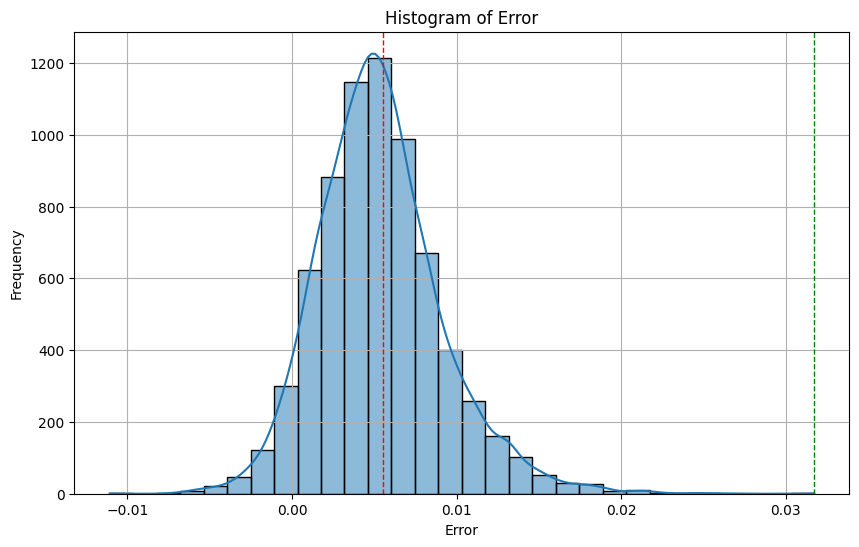

In [16]:
print("At depth: ",depth, "m -------------------" )
# avg absolute error
avg_abs_error = df['d_error'].abs().mean()
print("Avg absolute error: ", avg_abs_error)
# error standard deviation
std_error = df['d_error'].std()
print("Standard deviation of error: ", std_error)
# highest error
max_error = df['d_error'].max()
print("Max error: ", max_error)
# histogram of error
plt.figure(figsize=(10, 6))
sns.histplot(df['d_error'], bins=30, kde=True)
plt.axvline(avg_abs_error, color='red', linestyle='dashed', linewidth=1, label='Avg Abs Error')
plt.axvline(max_error, color='green', linestyle='dashed', linewidth=1, label='Max Error')
plt.title('Histogram of Error')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid()
plt.show()

In [17]:
# save the dataframe to csv file

df.to_csv(f'pmel_results_d{int(depth)}.csv', index=False)